In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost 
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
#from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
import glob
brand_dict = dict()
path = "Datasets/*_features.csv"
for fname in glob.glob(path):
    brand = fname.split('/')[1].split('_')[0]
    brand_dict[brand] = pd.read_csv(fname)
    brand_dict[brand].dropna(inplace=True)

In [3]:
print(len(brand_dict["Carters"].columns), brand_dict["Carters"].columns)

43 Index(['Unnamed: 0', 'Date', 'avg_comments', 'avg_bookmarks', 'avg_shares',
       'year', 'month', 'day', 'weekday', 'discount_today', 'avg_discount',
       'Y_discount_1d', 'Y_avg_discount_1d', 'Y_discount_3d',
       'Y_avg_discount_3d', 'Y_discount_7d', 'Y_avg_discount_7d',
       'Y_discount_14d', 'Y_avg_discount_14d', 'discount_past1day',
       'discount_past2day', 'discount_past3day', 'discount_past4day',
       'discount_past5day', 'discount_past6day', 'discount_past7day',
       'discount_min_past15day', 'discount_min_past30day',
       'discount_max_past15day', 'discount_max_past30day',
       'discount_mean_past15day', 'discount_mean_past30day',
       'nday_away_Martin_Luther_King_Jr_Day', 'nday_away_Columbus_Day',
       'nday_away_Labor_Day', 'nday_away_New_Years_Day',
       'nday_away_Thanksgiving', 'nday_away_Memorial_Day',
       'nday_away_Christmas_Day', 'nday_away_Washingtons_Birthday',
       'nday_away_Veterans_Day', 'nday_away_Independence_Day',
       'nda

In [4]:
brand_dict["Carters"].sort_values(by="Date", inplace=True)
X = brand_dict["Carters"][[
       'month', 'day', 'weekday', 'avg_discount', 
        'discount_past1day', 'discount_past2day',
       'discount_past3day', 'discount_past4day', 'discount_past5day',
       'discount_past6day', 'discount_past7day', 'discount_min_past15day',
       'discount_min_past30day', 'discount_max_past15day',
       'discount_max_past30day', 'discount_mean_past15day',
       'discount_mean_past30day', 'nday_away_Martin_Luther_King_Jr_Day',
       'nday_away_New_Years_Day', 'nday_away_Memorial_Day',
       'nday_away_Columbus_Day', 'nday_away_Veterans_Day',
       'nday_away_Independence_Day', 'nday_away_Labor_Day',
       'nday_away_Washingtons_Birthday', 'nday_away_Thanksgiving',
       'nday_away_Christmas_Day', 'nday_away_anyholiday']]
print(len(X.columns))

28


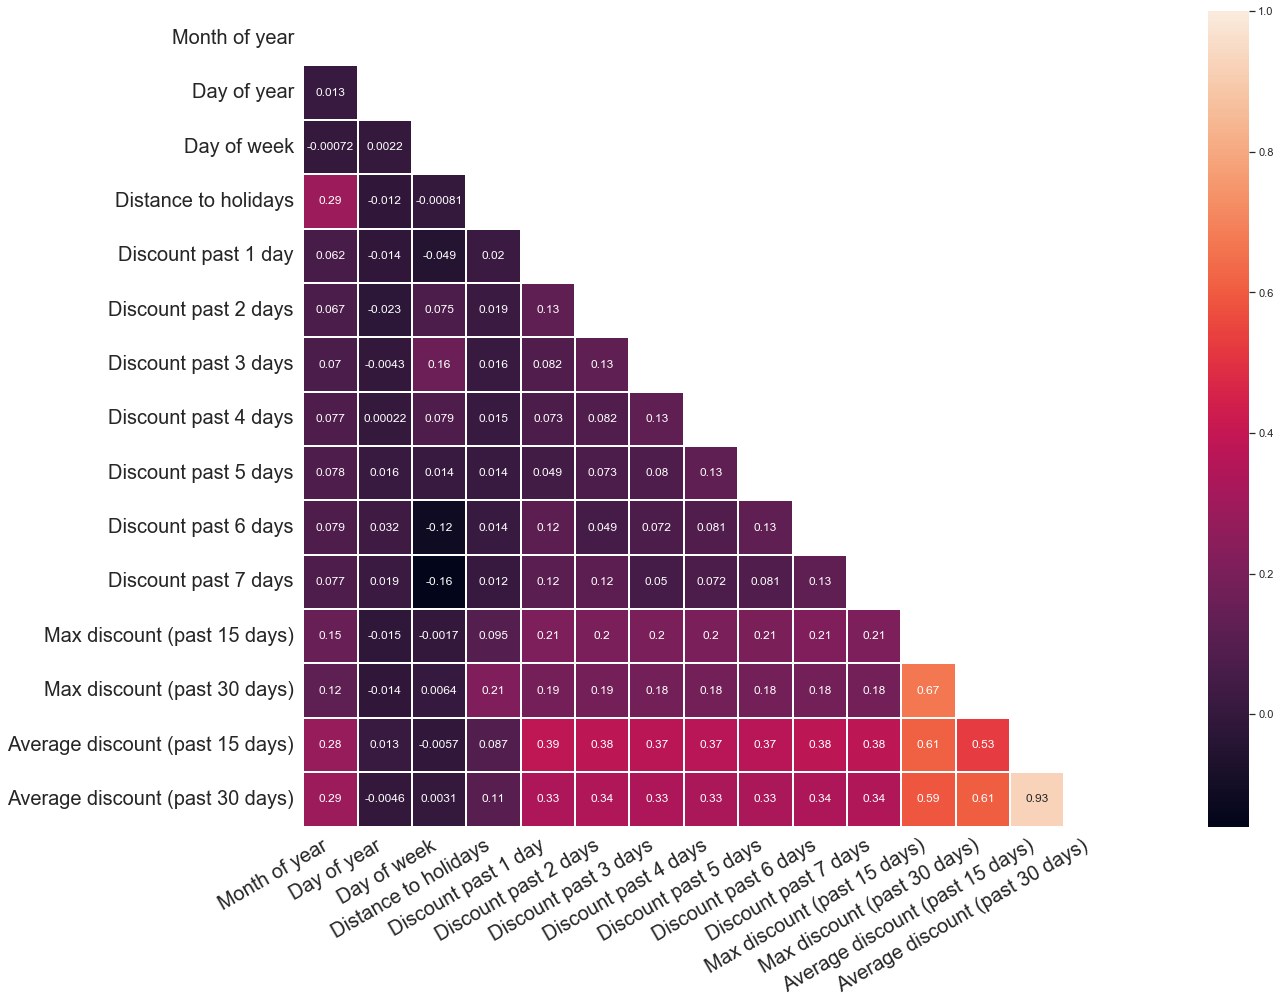

In [31]:
features_n = brand_dict["Carters"][[ 
       'month', 'day', 'weekday', 'nday_away_anyholiday', 
       'discount_past1day', 'discount_past2day',
       'discount_past3day', 'discount_past4day', 'discount_past5day',
       'discount_past6day', 'discount_past7day',
       'discount_max_past15day', 'discount_max_past30day', 'discount_mean_past15day', 'discount_mean_past30day']]
corr = features_n.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
plt.figure(figsize = (32,15))
ax = sns.heatmap(corr, mask=mask, annot=True,
            square=True, linewidths=1,cbar=True)
ax.set_yticklabels(
    ['Month of year', 'Day of year', 'Day of week', 'Distance to holidays',
     'Discount past 1 day', 'Discount past 2 days', 'Discount past 3 days', 
     'Discount past 4 days', 'Discount past 5 days', 'Discount past 6 days', 'Discount past 7 days',
     'Max discount (past 15 days)', 'Max discount (past 30 days)', 
     'Average discount (past 15 days)', 'Average discount (past 30 days)'],
    fontsize = 20,
    verticalalignment = 'center'
);
ax.set_xticklabels(
    ['Month of year', 'Day of year', 'Day of week', 'Distance to holidays',
     'Discount past 1 day', 'Discount past 2 days', 'Discount past 3 days', 
     'Discount past 4 days', 'Discount past 5 days', 'Discount past 6 days', 'Discount past 7 days',
     'Max discount (past 15 days)', 'Max discount (past 30 days)', 
     'Average discount (past 15 days)', 'Average discount (past 30 days)'],
    rotation = 30,
    fontsize = 20,
    horizontalalignment = 'right'
);

In [6]:
brand_dict["Carters"]['avg_discount'].unique()

array([ 0.        , 50.        , 25.        , 60.        , 15.        ,
       40.        , 20.        , 42.5       , 70.        , 45.        ,
       32.5       , 35.        , 55.        , 30.        , 27.5       ,
       75.        , 46.66666794, 37.5       , 47.5       , 65.        ,
       52.5       , 53.33333206, 57.66666794, 45.5       , 41.66666794,
       48.        , 62.33333206, 36.66666794, 43.33333206, 41.25      ,
       56.66666794, 58.        , 80.        , 43.75      , 46.25      ,
       26.66666603, 58.33333206, 38.        , 59.66666794, 48.57143021,
       48.75      , 72.5       , 61.66666794, 64.        , 52.        ,
       57.5       , 81.        , 56.57143021, 86.        , 51.11111069,
       67.5       , 62.5       , 28.75      , 31.66666603, 33.33333206,
       47.40000153, 47.33333206, 39.        , 79.        , 68.33333588,
       53.5       , 52.8571434 , 58.75      , 63.33333206, 43.125     ,
       59.        ])

/Users/universebright/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


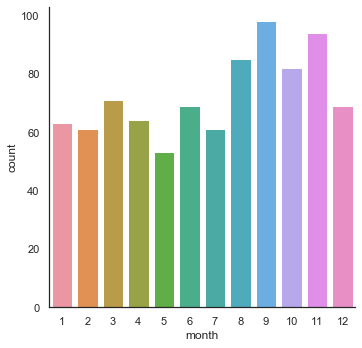

In [37]:
data_year = brand_dict["Carters"][brand_dict["Carters"]['discount_today'] == 1] 
sns.factorplot('month', data = data_year, kind='count')


### Label multi-class


[50  0 30 60 20 40 70 80]


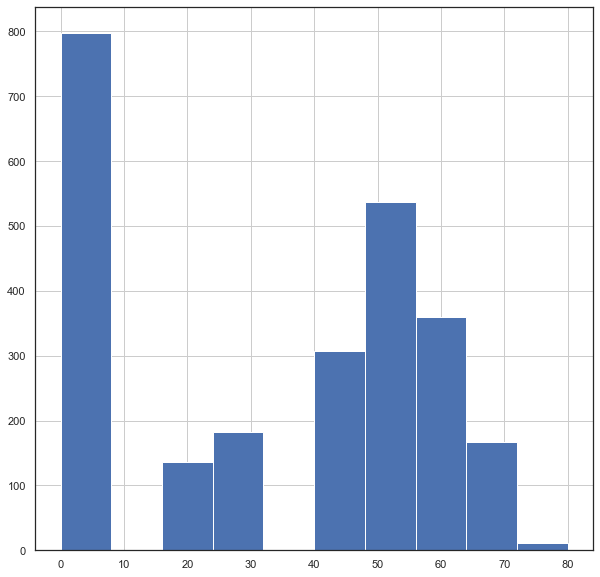

In [32]:
print(brand_dict["Carters"]["Y_avg_discount_3d"].unique())
brand_dict["Carters"]["Y_avg_discount_3d"].hist()

In [9]:
brand_dict["Carters"]['label'] = 0
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 20, 'label'] = 0
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 30, 'label'] = 0
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 40, 'label'] = 0
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 50, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 60, 'label'] = 2
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 70, 'label'] = 2
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_7d'] == 80, 'label'] = 2
condition0a = brand_dict["Carters"]['Y_avg_discount_7d'] >= 0
condition0b = brand_dict["Carters"]['Y_avg_discount_7d'] <= 45
condition1a = brand_dict["Carters"]['Y_avg_discount_7d'] >= 46
condition1b = brand_dict["Carters"]['Y_avg_discount_7d'] <= 55
condition2a = brand_dict["Carters"]['Y_avg_discount_7d'] >= 56
condition2b = brand_dict["Carters"]['Y_avg_discount_7d'] <= 95
print("0 -- 45%")
print(brand_dict["Carters"].loc[condition0a & condition0b, 'Y_avg_discount_7d'].mean() )
print(brand_dict["Carters"].loc[condition0a & condition0b, 'Y_avg_discount_7d'].std() )
print('\n')
print("46 -- 55%")
print(brand_dict["Carters"].loc[condition1a & condition1b, 'Y_avg_discount_7d'].mean() )
print(brand_dict["Carters"].loc[condition1a & condition1b, 'Y_avg_discount_7d'].std() )
print('\n')
print("56 -- 95%")
print(brand_dict["Carters"].loc[condition2a & condition2b, 'Y_avg_discount_7d'].mean() )
print(brand_dict["Carters"].loc[condition2a & condition2b, 'Y_avg_discount_7d'].std() )

0 -- 45%
27.62402088772846
15.728909251992045


46 -- 55%
50.0
0.0


56 -- 95%
62.5645438898451
4.712205282859771


In [10]:
brand_dict["Carters"]['label'] = 0
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 20, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 30, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 40, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 50, 'label'] = 1
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 60, 'label'] = 2
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 70, 'label'] = 2
brand_dict["Carters"].loc[brand_dict["Carters"]['Y_avg_discount_3d'] == 80, 'label'] = 2

In [11]:
y = brand_dict["Carters"]['label']

In [12]:
X_lastday, y_lastday = X.iloc[-1:, ], y.iloc[-1:, ]
X,y = X.iloc[0:-1, ], y.iloc[0:-1, ]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train, X_validate, X_test = np.split(X.sample(frac=1), [int(.8*len(X)), int(.9*len(X))])
#y_train, y_validate, y_test = np.split(y.sample(frac=1), [int(.8*len(y)), int(.9*len(y))])

In [13]:
print(X_lastday)
print("\n")
print(y_lastday)

      month  day  weekday  avg_discount  discount_past1day  discount_past2day  \
2529      1   18        5           0.0                0.0                1.0   

      discount_past3day  discount_past4day  discount_past5day  \
2529                0.0                1.0                1.0   

      discount_past6day  ...  nday_away_New_Years_Day  nday_away_Memorial_Day  \
2529                0.0  ...                 0.519271            7.330320e-17   

      nday_away_Columbus_Day  nday_away_Veterans_Day  \
2529            8.397145e-10                0.000028   

      nday_away_Independence_Day  nday_away_Labor_Day  \
2529                1.603811e-28         1.760228e-19   

      nday_away_Washingtons_Birthday  nday_away_Thanksgiving  \
2529                        0.129923                0.002745   

      nday_away_Christmas_Day  nday_away_anyholiday  
2529                 0.270868              0.990971  

[1 rows x 28 columns]


2529    2
Name: label, dtype: int64


### Modeling

First, try Logistic Regression as Baseline Model

In [14]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.5054545454545455


/Users/universebright/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
y_hat_train = logisticRegr.predict(X_train)
y_hat_test = logisticRegr.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)
plt.figure(1)
y_pred_prob = logisticRegr.predict_proba(X_test)[:, 1]
#fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
#plt.plot(fpr_grd,tpr_grd)
#auc(fpr_grd,tpr_grd)

              precision    recall  f1-score   support

           0       0.52      0.40      0.45       532
           1       0.55      0.75      0.63       789
           2       0.53      0.28      0.37       353

    accuracy                           0.54      1674
   macro avg       0.53      0.48      0.48      1674
weighted avg       0.54      0.54      0.52      1674

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       266
           1       0.52      0.70      0.60       374
           2       0.60      0.27      0.37       185

    accuracy                           0.51       825
   macro avg       0.52      0.45      0.46       825
weighted avg       0.51      0.51      0.49       825

Confusion Matrix:
[[213 286  33]
 [143 592  54]
 [ 50 204  99]]
[[104 147  15]
 [ 93 263  18]
 [ 35 100  50]]


<Figure size 432x288 with 0 Axes>

Next try XGBoost model

In [16]:
xgb = XGBClassifier(random_state=2)
xgb.fit(X_train, np.array(y_train))
xgb.score(X_test,y_test)

0.5781818181818181

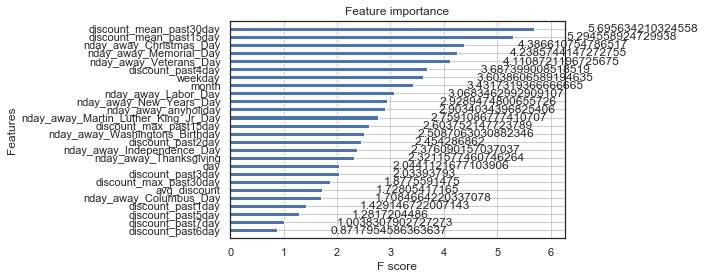

In [17]:
plot_importance(xgb, importance_type='gain', title='Feature importance', height=0.5)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [18]:
y_hat_train = xgb.predict(X_train)
y_hat_test = xgb.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
#fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
#plt.plot(fpr_grd,tpr_grd)
#auc(fpr_grd,tpr_grd)

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       532
           1       0.71      0.86      0.78       789
           2       0.78      0.53      0.63       353

    accuracy                           0.73      1674
   macro avg       0.75      0.69      0.71      1674
weighted avg       0.74      0.73      0.73      1674

              precision    recall  f1-score   support

           0       0.51      0.51      0.51       266
           1       0.60      0.70      0.64       374
           2       0.67      0.44      0.53       185

    accuracy                           0.58       825
   macro avg       0.59      0.55      0.56       825
weighted avg       0.58      0.58      0.57       825

Confusion Matrix:
[[356 150  26]
 [ 79 682  28]
 [ 40 126 187]]
[[135 119  12]
 [ 85 261  28]
 [ 46  58  81]]


<Figure size 720x720 with 0 Axes>

In [20]:
estimator = XGBClassifier(
    objective= 'multi:softmax',
    nthread=4,
    seed=42,
    num_class=3,
)

In [21]:
 parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1_macro', # or 'f1_micro', ‘f1_weighted’
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(X_test, y_test)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  6.2min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:  8.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, num_class=3,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                      

In [27]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)

In [28]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)
xgb.fit(X_train, np.array(y_train))
xgb.score(X_test, y_test)

0.6521212121212121

In [33]:
y_hat_train = xgb.predict(X_train)
y_hat_test = xgb.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = xgb.predict_proba(X_test) #[:, 1]
print(y_pred_prob[0:5])

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       266
           1       0.66      0.75      0.70       374
           2       0.72      0.57      0.64       185

    accuracy                           0.65       825
   macro avg       0.66      0.63      0.64       825
weighted avg       0.65      0.65      0.65       825

Confusion Matrix:
[[532   0   0]
 [  0 789   0]
 [  0   0 353]]
[[151 100  15]
 [ 66 281  27]
 [ 31  48 106]]
[[0.58578336 0.16542958 0.24878709]
 [0.37082458 0.5812944  0.047881  ]
 [0.07842343 0.9168754  0.0047011 ]
 [0.6521988  0.23946318 0.10833803]
 [0.00819786 0.33953455 0.6522676 ]]


<Figure size 720x720 with 0 Axes>

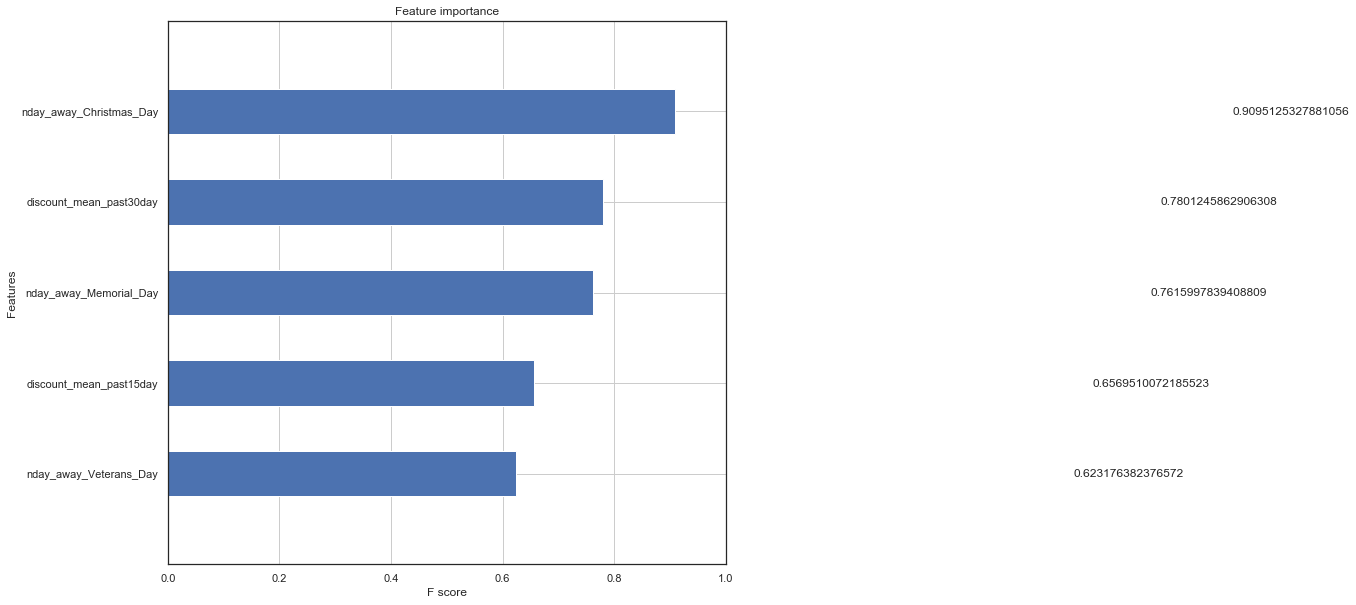

In [30]:
plot_importance(xgb, importance_type='gain', max_num_features=5, title='Feature importance', height=0.5)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [26]:
y_hat_lastday = xgb.predict(X_lastday)
y_hat_lastday

array([1])